In [2]:
#imports
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Conv2D, Flatten, Dense, ReLU, Reshape, Conv2DTranspose
from keras.models import Model
import numpy as np
import keras.backend as K

In [16]:
class VAE:
    def __init__(self, batch_size, epochs):
        self.number_of_rows = 28
        self.number_of_columns = 28
        self.number_of_channels = 1
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()
        self.variational_autoencoder = self.build_autoencoder()
        self.batch_size = batch_size
        self.optimizer = keras.optimizers.Adam()
        self.epochs = epochs
        self.reconstruction_loss_weight = 500





    def build_encoder(self):
        input = Input(shape=(self.number_of_rows, self.number_of_columns, self.number_of_channels))
        x = Conv2D(32, kernel_size=3, strides=2, padding="same")(input)
        x = ReLU()(x)
        x = Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
        x = ReLU()(x)
        self.shape_before_flattening = K.int_shape(x)[1:]
        x = Flatten()(x)
        z_mean = Dense(2)(x)
        z_log = Dense(2)(x)

        return Model(input, [z_mean, z_log])



    def build_decoder(self):
        input = Input(shape=(2,))
        x = Dense(np.prod(self.shape_before_flattening))(input)
        x = Reshape(self.shape_before_flattening)(x)
        x = Conv2DTranspose(64, kernel_size=3, strides=2, padding="same")(x)
        x = ReLU()(x)
        x = Conv2DTranspose(32, kernel_size=3, strides=2, padding="same")(x)
        x = ReLU()(x)
        output = Conv2DTranspose(1, kernel_size=3, strides=1, padding="same", activation="sigmoid")(x)

        return Model(input, output)




    def sample_from_gaussian(self, inputs):
        z_mean, z_log = inputs
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], 2))

        return z_mean + tf.exp(z_log / 2) * epsilon



    def build_autoencoder(self):
        input = Input(shape=(self.number_of_rows, self.number_of_columns, self.number_of_channels))
        x = self.encoder(input)
        x = self.sample_from_gaussian(x)
        output = self.decoder(x)

        return Model(input, output)

    def reconstruction_loss(self, input, target): # rms loss

        return tf.math.sqrt(tf.reduce_mean(tf.math.pow(input - target, 2)))


    def KL_loss(self, z_mean, z_log):

        return tf.reduce_mean(tf.reduce_sum(-0.5*(1 + z_log - tf.square(z_mean) -tf.exp(z_log)), axis = 1))


    def train_VAE(self):

        self.variational_autoencoder.compile(optimizer="adam")

        train_dataset = self.load_dataset()

        for epoch in range(self.epochs):
            kl_loss_temp = []
            reconstruction_loss_temp = []
            total_loss_temp = []
            for batch, _ in train_dataset:
                with tf.GradientTape() as tape:
                    z_mean, z_log = self.encoder(batch)
                    z = self.sample_from_gaussian([z_mean, z_log])
                    predict = self.decoder(z)
                    reconstruction_loss = self.reconstruction_loss(batch, predict)
                    kl_loss = self.KL_loss(z_mean, z_log)
                    total_loss = self.reconstruction_loss_weight*reconstruction_loss + kl_loss
                grads = tape.gradient(total_loss, self.variational_autoencoder.trainable_weights)
                self.optimizer.apply_gradients(zip(grads, self.variational_autoencoder.trainable_weights))

                kl_loss_temp.append(kl_loss.numpy())
                reconstruction_loss_temp.append(reconstruction_loss.numpy())
                total_loss_temp.append(total_loss.numpy())

            avg_kl_loss = np.mean(kl_loss_temp)
            avg_reconstruction_loss = np.mean(reconstruction_loss_temp)
            avg_total_loss = np.mean(total_loss_temp)

            print(f"Epoch {epoch + 1}/{self.epochs}, KL Loss: {avg_kl_loss}, Reconstruction Loss: {avg_reconstruction_loss}, Total Loss: {avg_total_loss}")


    def load_dataset(self):
        # Load MNIST dataset
        (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

        # Normalize pixel values to be between 0 and 1
        train_images, test_images = train_images / 255.0, test_images / 255.0

        train_images = train_images.reshape(-1, 28, 28, 1).astype('float32')

        # Create a tf.data.Dataset for training data
        train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))

        # Shuffle and batch the dataset
        train_dataset = train_dataset.shuffle(buffer_size=60000).batch(self.batch_size)
        return train_dataset


In [17]:
vae = VAE(batch_size = 128, epochs = 100)
vae.train_VAE()

Epoch 1/100, KL Loss: 2.6693522930145264, Reconstruction Loss: 0.24989400804042816, Total Loss: 127.61637115478516
Epoch 2/100, KL Loss: 3.775561571121216, Reconstruction Loss: 0.22329246997833252, Total Loss: 115.42179107666016
Epoch 3/100, KL Loss: 4.238829135894775, Reconstruction Loss: 0.21720027923583984, Total Loss: 112.8389663696289
Epoch 4/100, KL Loss: 4.459503173828125, Reconstruction Loss: 0.21456919610500336, Total Loss: 111.74410247802734
Epoch 5/100, KL Loss: 4.590938091278076, Reconstruction Loss: 0.21288223564624786, Total Loss: 111.03205108642578
Epoch 6/100, KL Loss: 4.696698188781738, Reconstruction Loss: 0.21159695088863373, Total Loss: 110.49517822265625
Epoch 7/100, KL Loss: 4.761358737945557, Reconstruction Loss: 0.21070019900798798, Total Loss: 110.11145782470703
Epoch 8/100, KL Loss: 4.812325954437256, Reconstruction Loss: 0.20991837978363037, Total Loss: 109.7715072631836
Epoch 9/100, KL Loss: 4.87160587310791, Reconstruction Loss: 0.20922888815402985, Total L

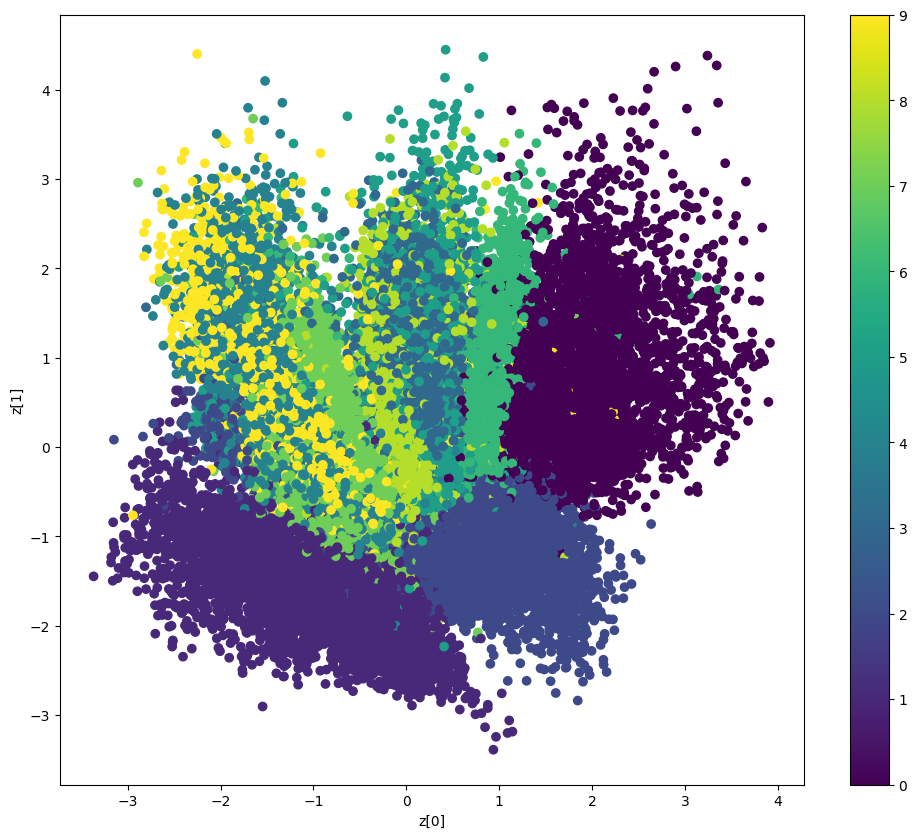

In [18]:
import matplotlib.pyplot as plt

def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _ = vae.encoder.predict(data, verbose=0)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)


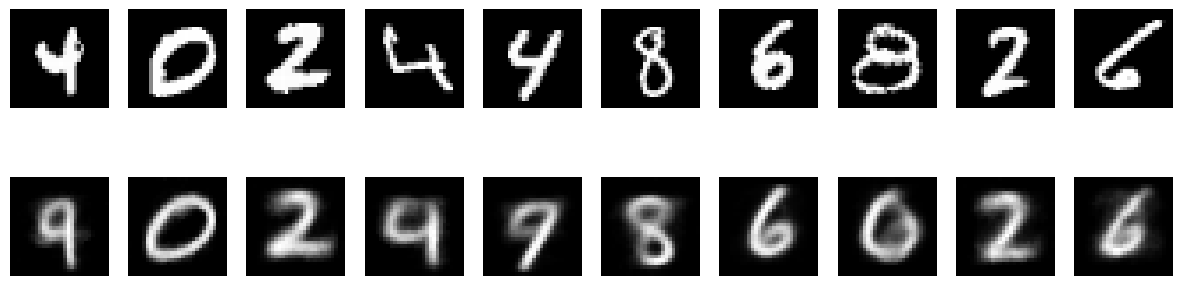

In [21]:
#reconstruction of images
def reconstruct_random_images(test_images, num_samples):

    random_indices = np.random.choice(len(test_images), num_samples, replace=False)
    original_images = test_images[random_indices]

    # Encode and decode the selected samples
    z_mean, z_log = vae.encoder(original_images)
    z = vae.sample_from_gaussian([z_mean, z_log])
    reconstructed_images = vae.decoder(z)

    # Plot the original and reconstructed images
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 4))
    for i in range(num_samples):
        axes[0, i].imshow(original_images[i, :, :, 0], cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed_images[i, :, :, 0], cmap='gray')
        axes[1, i].axis('off')

    plt.show()

reconstruct_random_images(test_images = x_train, num_samples = 10)

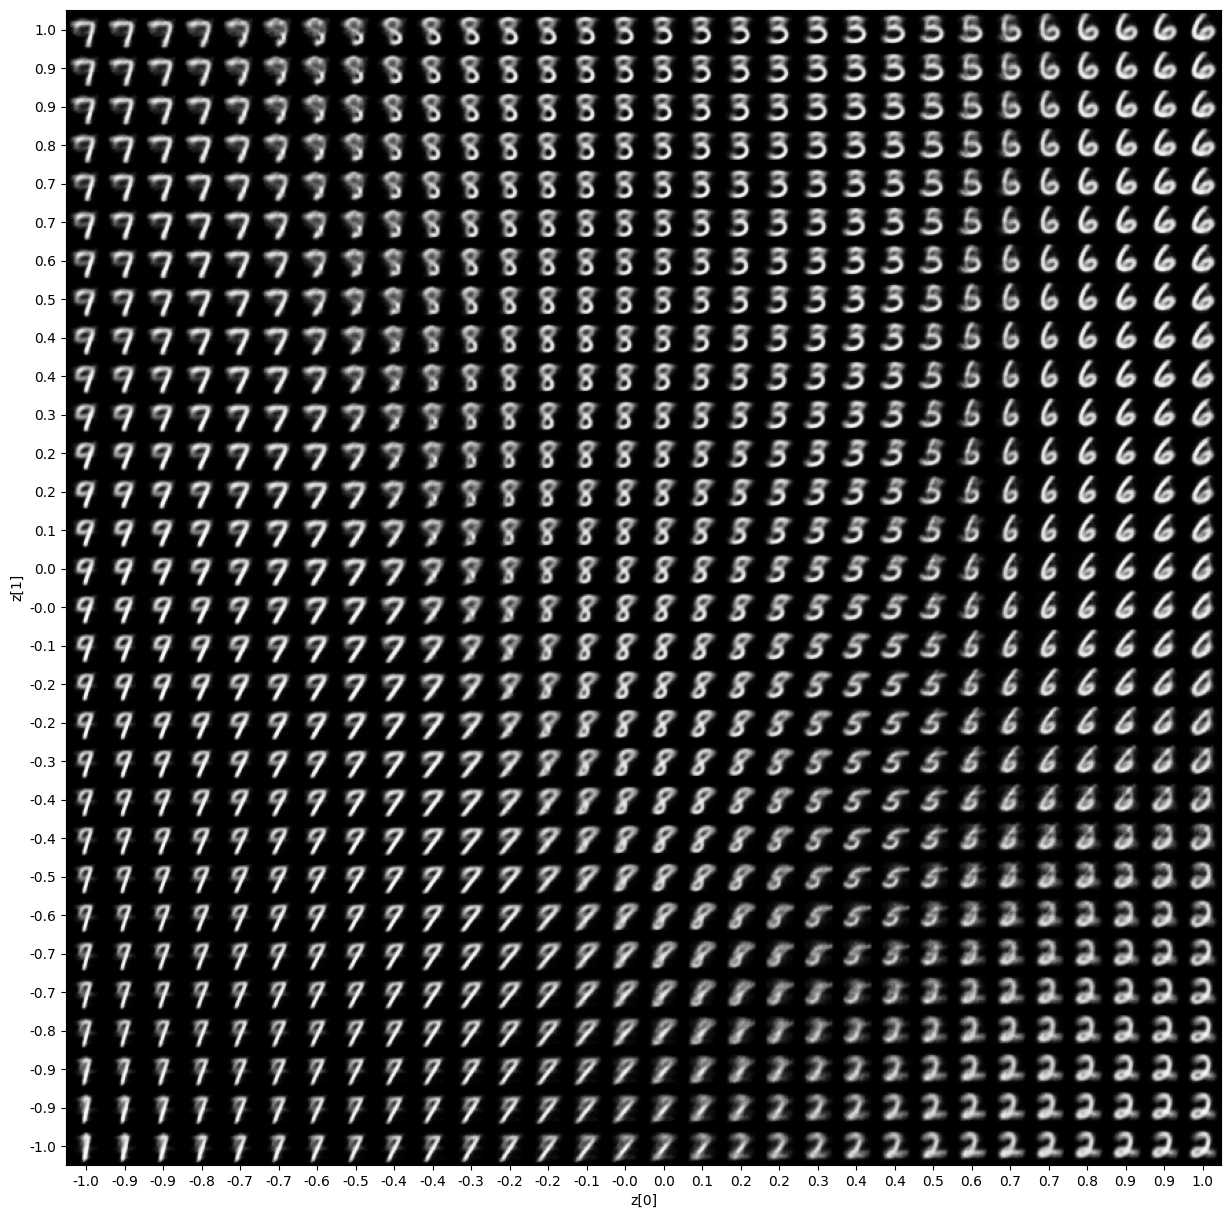

In [22]:
import matplotlib.pyplot as plt


def plot_latent_space(autoencoder, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample, verbose=0)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(autoencoder = vae)


In [30]:
vae.encoder.save("encoder.h5")
vae.decoder.save("decoder.h5")
vae.variational_autoencoder.save("vae.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
